# **Latar Belakang**

Pada industri Software as a Service(SaaS), mengoptimalkan strategi penjualan dan pemasaran berdasarkan analisis data yang tepat adalah kunci untuk mendapatkan keunggulan kompetitif dan memaksimalkan efisiensi operasional. Industri SaaS, dengan produk-produk berbasis langganan dan tingkat kompetisi yang tinggi, menuntut pemahaman yang mendalam tentang dinamika penjualan untuk mengidentifikasi peluang pertumbuhan dan peningkatan keuntungan.

Faktor-faktor seperti pengaruh diskon, pengaruh segmentasi, pengaruh region, dan preferensi pelanggan terhadap fitur produk harus dianalisis secara detail untuk merancang tawaran yang lebih menarik dan meningkatkan kepuasan pelanggan. Penyesuaian pada strategi ini dapat secara signifikan mempengaruhi keberhasilan penjualan dan keberlanjutan bisnis dalam pasar yang kompetitif.

# **Pernyataan Masalah**

Tujuan dari analisis ini adalah untuk mengetahui:


1. Bagaimana Tren Penjualan dan Keuntungan?
2. Siapa Customer Paling Berharga?
3. Faktor Apa Saja Yang Mempengaruhi Keuntungan?

# **Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind
from operator import attrgetter
from matplotlib import ticker
import matplotlib.dates as mdates
import warnings
from scipy.stats import kruskal
warnings.filterwarnings("ignore")


# **Pembuatan Fungsi**

In [2]:
def upper_bound(series):
    q3 = series.quantile(0.75)
    q1 = series.quantile(0.25)
    iqr = q3 - q1
    return q3 + 1.5 * iqr

def lower_bound(series):
    q3 = series.quantile(0.75)
    q1 = series.quantile(0.25)
    iqr = q3 - q1
    return q1 - 1.5 * iqr

def count_upper_outliers(series):
    ub = upper_bound(series)
    return series[series > ub].count()

def count_lower_outliers(series):
    lb = lower_bound(series)
    return series[series < lb].count()

custom_agg_functions = {
    'Sales': [
        'median', 'max', 'min', 
        lambda x: upper_bound(x), 
        lambda x: lower_bound(x),
        lambda x: count_upper_outliers(x),
        lambda x: count_lower_outliers(x)
    ],
    'Profit': [
        'median', 'max', 'min', 
        lambda x: upper_bound(x), 
        lambda x: lower_bound(x),
        lambda x: count_upper_outliers(x),
        lambda x: count_lower_outliers(x)
    ]
}

renamed_aggregations = {
    'median': 'median',
    'max': 'max',
    'min': 'min',
    '<lambda_0>': 'upper_bound',
    '<lambda_1>': 'lower_bound',
    '<lambda_2>': 'count_upper_outliers',
    '<lambda_3>': 'count_lower_outliers'
}

def create_bar(x, y, col):
    sns.barplot(data=data, x=x, y=y, ci=0, color = 'navy', estimator=np.median)
    plt.title(f'Median {y} Area by {col}')
    plt.show()
    
    
def categorize_profit(value):
    if value < 0:
        return 'Loss'
    elif value == 0:
        return 'BEP'
    else:
        return 'Profit'

def R_score(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

def FM_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

def label_customer(row):
    if row['R_score'] == 4 and row['F_score'] == 4 and row['M_score'] == 4:
        return 'Champions'
    elif row['F_score'] >= 3 and row['M_score'] >= 3:
        return 'Loyal Customers'
    elif row['R_score'] >= 3 and (row['F_score'] >= 2 or row['M_score'] >= 2):
        return 'Potential Loyalist'
    elif row['R_score'] == 4 and row['F_score'] <= 1 and row['M_score'] <= 1:
        return 'New Customers'
    elif row['R_score'] <= 2 and row['F_score'] >= 3:
        return 'At Risk'
    elif row['R_score'] <= 2 and row['F_score'] <= 2 and row['M_score'] >= 3:
        return 'Can’t Lose Them'
    else:
        return 'Hibernating'



# **Data Preparation**

Persiapan terkait data, meliputi:
1. Loading Dataset
2. Data Understanding

## **Loading Dataset**

In [3]:
df = pd.read_csv('SaaS-Sales.csv') # menyimpan dataframe dengan variable df
df.head(5) # menampilkan 5 data teratas

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164


## **Data Understanding**

### **Informasi Data**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Row ID        9994 non-null   int64  
 1   Order ID      9994 non-null   object 
 2   Order Date    9994 non-null   object 
 3   Date Key      9994 non-null   int64  
 4   Contact Name  9994 non-null   object 
 5   Country       9994 non-null   object 
 6   City          9994 non-null   object 
 7   Region        9994 non-null   object 
 8   Subregion     9994 non-null   object 
 9   Customer      9994 non-null   object 
 10  Customer ID   9994 non-null   int64  
 11  Industry      9994 non-null   object 
 12  Segment       9994 non-null   object 
 13  Product       9994 non-null   object 
 14  License       9994 non-null   object 
 15  Sales         9994 non-null   float64
 16  Quantity      9994 non-null   int64  
 17  Discount      9994 non-null   float64
 18  Profit        9994 non-null 

Terdapat 9994 jumlah data dengan 19 kolom

Dataset ini berisi informasi terkait informasi penjualan Software as a Service(SaaS) dari Amazon. Ada 19 kolom di dalam dataset, yaitu:

| Column Name   | Description                                      |
|---------------|--------------------------------------------------|
| Row ID        | Kode unik setiap baris pada tabel.              |
| Order ID      | Kode unik pemesanan.                             |
| Order Date    | Tanggal pemesanan.                                |
| Date Key      | Key Tanggal yang mungkin digunakan untuk menghubungkan data dengan kunci tanggal di tabel lain. |
| Contact Name  | Nama kontak pemesan.                             |
| Country       | Negara pemesan.                                  |
| City          | Kota pemesan.                                    |
| Region        | Wilayah pemesan.                                 |
| Subregion     | Subwilayah pemesan.                              |
| Customer      | Nama Customer.                                   |
| Customer ID   | Kode Unik pelanggan.                             |
| Industry      | Industri pelanggan.                              |
| Segment       | Segmen bisnis pelanggan.                         |
| Product       | Produk yang dipesan.                             |
| License       | Kode unik untuk produk terkait.                  |
| Sales         | Total penjualan untuk pesanan tersebut.          |
| Quantity      | Jumlah unit produk yang dipesan.                 |
| Discount      | Diskon yang diberikan pada pesanan (dalam persen).|
| Profit        | Keuntungan yang dihasilkan dari pesanan tersebut. |


In [5]:
# data uni di tiap kolom
list_kolom = []
for col in df.columns :
    list_kolom.append( [col, df[col].nunique(), df[col].unique()])

tabel_unik = pd.DataFrame(columns=['Name Kolom', 'Jumlah Nilai Unik', 'Sample'],
                     data=list_kolom)

### **Nilai Unik Tiap Kolom**

In [6]:
display(tabel_unik)

,Name Kolom,Jumlah Nilai Unik,Sample
0,Row ID,9994,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,Order ID,5009,"[EMEA-2022-152156, AMER-2022-138688, EMEA-2021..."
2,Order Date,1237,"[11/9/2022, 6/13/2022, 10/11/2021, 6/9/2020, 4..."
3,Date Key,1237,"[20221109, 20220613, 20211011, 20200609, 20230..."
4,Contact Name,793,"[Nathan Bell, Deirdre Bailey, Zoe Hodges, Thom..."
5,Country,48,"[Ireland, United States, Germany, Sweden, Cana..."
6,City,262,"[Dublin, New York City, Stuttgart, Stockholm, ..."
7,Region,3,"[EMEA, AMER, APJ]"
8,Subregion,12,"[UKIR, NAMER, EU-WEST, NOR, JAPN, EU, MEA, LAT..."
9,Customer,99,"[Chevron, Phillips 66, Royal Dutch Shell, BNP ..."


- Data mencakup 1237 hari transaksi unik, menunjukkan data diambil selama >3 tahun.
- 793 nama kontak pelanggan unik, baik untuk analisis segmentasi pelanggan.
- Transaksi di 48 negara, menunjukkan jangkauan geografis operasi yang luas.
- 262 kota yang berbeda, penting untuk analisis pasar geografis.
- Pembagian data ke dalam 3 region besar, berguna untuk analisis regional.
- 12 subregion menunjukkan segmentasi pasar lebih detil.
- 99 pelanggan unik, memungkinkan analisis per pelanggan.
- ID unik per pelanggan, menyederhanakan tracking dan analisis CRM.
- Pelanggan dari 10 industri berbeda, menyediakan basis untuk segmentasi industri.
- Tiga segment pasar, memudahkan analisis berdasarkan ukuran pelanggan.
- 14 produk yang ditawarkan, analisis produk individu dapat mengungkap performer utama.
- Lisensi produk yang unik per transaksi, menunjukkan kontrol yang baik atas inventaris produk.
- Beragam tingkat diskon diterapkan, analisis ini dapat membantu dalam strategi penetapan diskon.
- Profit untuk setiap transaksi juga bervariasi, menginformasikan margin dan efisiensi operasional.

### **Deskripsi Statistik Data**

Melakukan analisa deskriptif untuk memahami distribusi dasar dari 'Sales', 'Profit', 'Discount', dan variabel lainnya dalam dataset. Analisis ini akan mencakup penghitungan statistik dasar seperti mean, median, modus, dan standar deviasi, serta visualisasi data untuk mendapatkan pemahaman intuitif tentang bentuk distribusi data.

In [7]:
# Deskripsi statistik untuk variabel numerik
descriptive_stats = df[['Sales', 'Profit', 'Quantity', 'Discount']].describe()
print(descriptive_stats)

              Sales       Profit     Quantity     Discount
count   9994.000000  9994.000000  9994.000000  9994.000000
mean     229.858001    28.656896     3.789574     0.156203
std      623.245101   234.260108     2.225110     0.206452
min        0.444000 -6599.978000     1.000000     0.000000
25%       17.280000     1.728750     2.000000     0.000000
50%       54.490000     8.666500     3.000000     0.200000
75%      209.940000    29.364000     5.000000     0.200000
max    22638.480000  8399.976000    14.000000     0.800000


1. Sales (Penjualan)
- Range Penjualan: Penjualan berkisar dari sangat kecil ($0.44) sampai sangat besar ($22,638.48), menunjukkan diversitas besar dalam ukuran transaksi.
- Rata-rata Penjualan: Rata-rata penjualan adalah $229.86, tetapi dengan deviasi standar yang besar ($623.25), ini mengindikasikan bahwa distribusi penjualan sangat lebar dan banyak outlier (transaksi yang sangat tinggi).
- Median Penjualan: Median ($54.49) yang jauh lebih rendah dari rata-rata menunjukkan bahwa sebagian besar transaksi cenderung kecil dan beberapa transaksi besar menaikkan rata-rata.
- Kuartil Penjualan: 75% dari penjualan berada di bawah $209.94, yang lagi-lagi menegaskan bahwa transaksi besar tidak umum.
2. Profit (Keuntungan)
- Range Keuntungan: Keuntungan berkisar dari sangat negatif (-$6599.98) hingga sangat positif ($8399.98), menunjukkan adanya transaksi yang mengakibatkan kerugian besar serta keuntungan besar.
- Rata-rata Keuntungan: Rata-rata keuntungan adalah $28.66, tapi seperti penjualan, deviasi standarnya ($234.26) tinggi, menunjukkan variabilitas besar dalam keuntungan per transaksi.
- Keuntungan Negatif: Minimum keuntungan yang sangat negatif menunjukkan beberapa transaksi yang menyebabkan kerugian besar, penting untuk diinvestigasi lebih lanjut.
- Median Keuntungan: Median keuntungan ($8.67) lebih rendah dari rata-rata, mirip dengan penjualan, menunjukkan bahwa kebanyakan transaksi menghasilkan keuntungan kecil.
3. Quantity (Kuantitas)
- Range Kuantitas: Kuantitas produk per transaksi berkisar dari 1 hingga 14 unit.
- Rata-rata Kuantitas: Rata-rata hampir 4 produk per transaksi, menunjukkan bahwa biasanya lebih dari satu item dibeli dalam setiap transaksi.
- Distribusi Kuantitas: Mayoritas transaksi (75%) melibatkan 5 produk atau kurang.
4. Discount (Diskon)
- Range Diskon: Diskon berkisar dari 0% hingga 80%.
- Rata-rata Diskon: Rata-rata diskon yang diberikan adalah 15.62%, dengan diskon 20% adalah yang paling umum (median).
- Distribusi Diskon: 50% transaksi memiliki diskon 20%, dan 75% transaksi memiliki diskon 20% atau lebih rendah, menunjukkan bahwa kebanyakan diskon tidak terlalu tinggi.

`Kesimpulan:`
1. Analisis Kerugian: Perlu ada penyelidikan terhadap transaksi yang menyebabkan kerugian besar untuk mengidentifikasi penyebab dan potensi meminimalkan kerugian di masa depan.
Fokus pada Transaksi Besar: Mengingat dampak signifikan dari transaksi besar terhadap rata-rata penjualan dan keuntungan, perlu strategi khusus untuk lebih menargetkan dan melayani transaksi-transaksi ini menggunakan RFM Analisis.

# **Data Cleaning & Processing**

Melakukan cleaning dan processing pada dataset melalui 6 tahapan, yaitu:
1. Handling Unnecessary Column
2. Handling Data Type
3. Handling Out Of Range Data
4. Handling Oultiers
5. Handling Missing Value
6. Handling Data Duplicate

### `Handling Unnecessary Column`
- Row ID hanya sebagai identifier yang tidak memberikan informasi analitis.
- Date Key merupakan representasi numerik dari 'Order Date' dan redundan.
- License adalah kunci produk yang spesifik dan tidak relevan untuk tren atau analisis agregat.

In [8]:
df.drop(columns=['Date Key','Row ID','License'], inplace=True)

### `Handling Data Type`

Mengubah Tipe Data 'Order Date' menjadi datetime, sehingga memudahkan dalam melakukan analisis tren waktu. 


In [9]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Customer ID'] = df['Customer ID'].astype(str)

Mengubah tipe data '

### `Handling Out Of Range Data`
Mencari data yang tidak seharusnya ada pada kolom:
- Sales (Bilangan Positif)
- Quantity (Minimal 1)
- Discount (Range 0-1)

In [10]:
df_out_of_range_test = df[['Sales', 'Quantity', 'Discount', 'Order Date']]
for col  in df_out_of_range_test:
    print('Pada Kolom', col, 'memiliki nilai terkecil:',df_out_of_range_test[col].values.min(), 'dan memiliki nilai terbesar:', df_out_of_range_test[col].values.max())

Pada Kolom Sales memiliki nilai terkecil: 0.444 dan memiliki nilai terbesar: 22638.48
Pada Kolom Quantity memiliki nilai terkecil: 1 dan memiliki nilai terbesar: 14
Pada Kolom Discount memiliki nilai terkecil: 0.0 dan memiliki nilai terbesar: 0.8
Pada Kolom Order Date memiliki nilai terkecil: 2020-01-04T00:00:00.000000000 dan memiliki nilai terbesar: 2023-12-31T00:00:00.000000000


Setelah melakukan pengecekan pada kolom 'Sales', 'Quantity', dan 'Discount', 'Order Date' dapat dilihat bahwa data masih pada range yang seharusnya

### `Handling Outlier`

Mencari outlier disetiap kolom numerikal

In [11]:
def cek_outlier(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    print(f'Kolom {column}: Batas Bawah: {lower_bound} dan Batas Atas: {upper_bound}')
    return lower_bound, upper_bound

In [12]:
for column in df.select_dtypes(include='number').columns:
    lower_bound, upper_bound = cek_outlier(column)  # Memperbaiki cara menyimpan batas atas dan batas bawah
    outlier_count = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
    outlier_percentage = (outlier_count / df.shape[0]) * 100
    print(f'Jumlah data outlier pada kolom {column}: {outlier_count} atau sebanyak {outlier_percentage:.2f} %\n')

Kolom Sales: Batas Bawah: -271.71000000000004 dan Batas Atas: 498.93
Jumlah data outlier pada kolom Sales: 1167 atau sebanyak 11.68 %

Kolom Quantity: Batas Bawah: -2.5 dan Batas Atas: 9.5
Jumlah data outlier pada kolom Quantity: 170 atau sebanyak 1.70 %

Kolom Discount: Batas Bawah: -0.30000000000000004 dan Batas Atas: 0.5
Jumlah data outlier pada kolom Discount: 856 atau sebanyak 8.57 %

Kolom Profit: Batas Bawah: -39.724125 dan Batas Atas: 70.816875
Jumlah data outlier pada kolom Profit: 1881 atau sebanyak 18.82 %



Outliers mungkin merepresentasikan data yang sangat relevan dari segi bisnis, seperti transaksi besar dan keuntungan atau kerguain secara besar. Menghapus outliers ini bisa menghilangkan wawasan penting tentang perilaku atau preferensi dari segmen pasar yang sangat bernilai.

### `Handling Missing Value`

Mencari missing value pada setiap kolom pada dataset

In [13]:
df.isna().sum()

Order ID        0
Order Date      0
Contact Name    0
Country         0
City            0
Region          0
Subregion       0
Customer        0
Customer ID     0
Industry        0
Segment         0
Product         0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

Tidak ada missing value di dataset ini, sehingga tidak perlu tindakan lebih lanjut pada tahap ini.

### `Handling Data Duplicate`

In [14]:
print('Total Data Duplikat:' , df.duplicated().sum())

Total Data Duplikat: 1


Tidak perlu ada yang dilakukan, karena tidak ada data duplikat

# **Exploratory Data Analysis (EDA)**

## **Numerical Features**

### **Data Distribution**

In [15]:
numerical = [var for var in df.columns if df[var].dtype in ['int64', 'float64']]
numerical

['Sales', 'Quantity', 'Discount', 'Profit']

In [16]:
from scipy.stats import normaltest

dist = []

for i in range(len(numerical)):
    feature_name = numerical[i]
    stat, p_value = normaltest(df[feature_name].dropna())
    
    if p_value > 0.05:
        distribution = "Normally Distributed"
    else:
        distribution = "Not Normally Distributed"
    
    dist.append([feature_name, stat, p_value, distribution])

dist_df = pd.DataFrame(dist, columns=['Feature', "D'Agostino-Pearson Statistic", 'P-value', 'Distributed'])
dist_df

,Feature,D'Agostino-Pearson Statistic,P-value,Distributed
0,Sales,18033.308498,0.0,Not Normally Distributed
1,Quantity,2148.018022,0.0,Not Normally Distributed
2,Discount,2977.822121,0.0,Not Normally Distributed
3,Profit,14363.736244,0.0,Not Normally Distributed


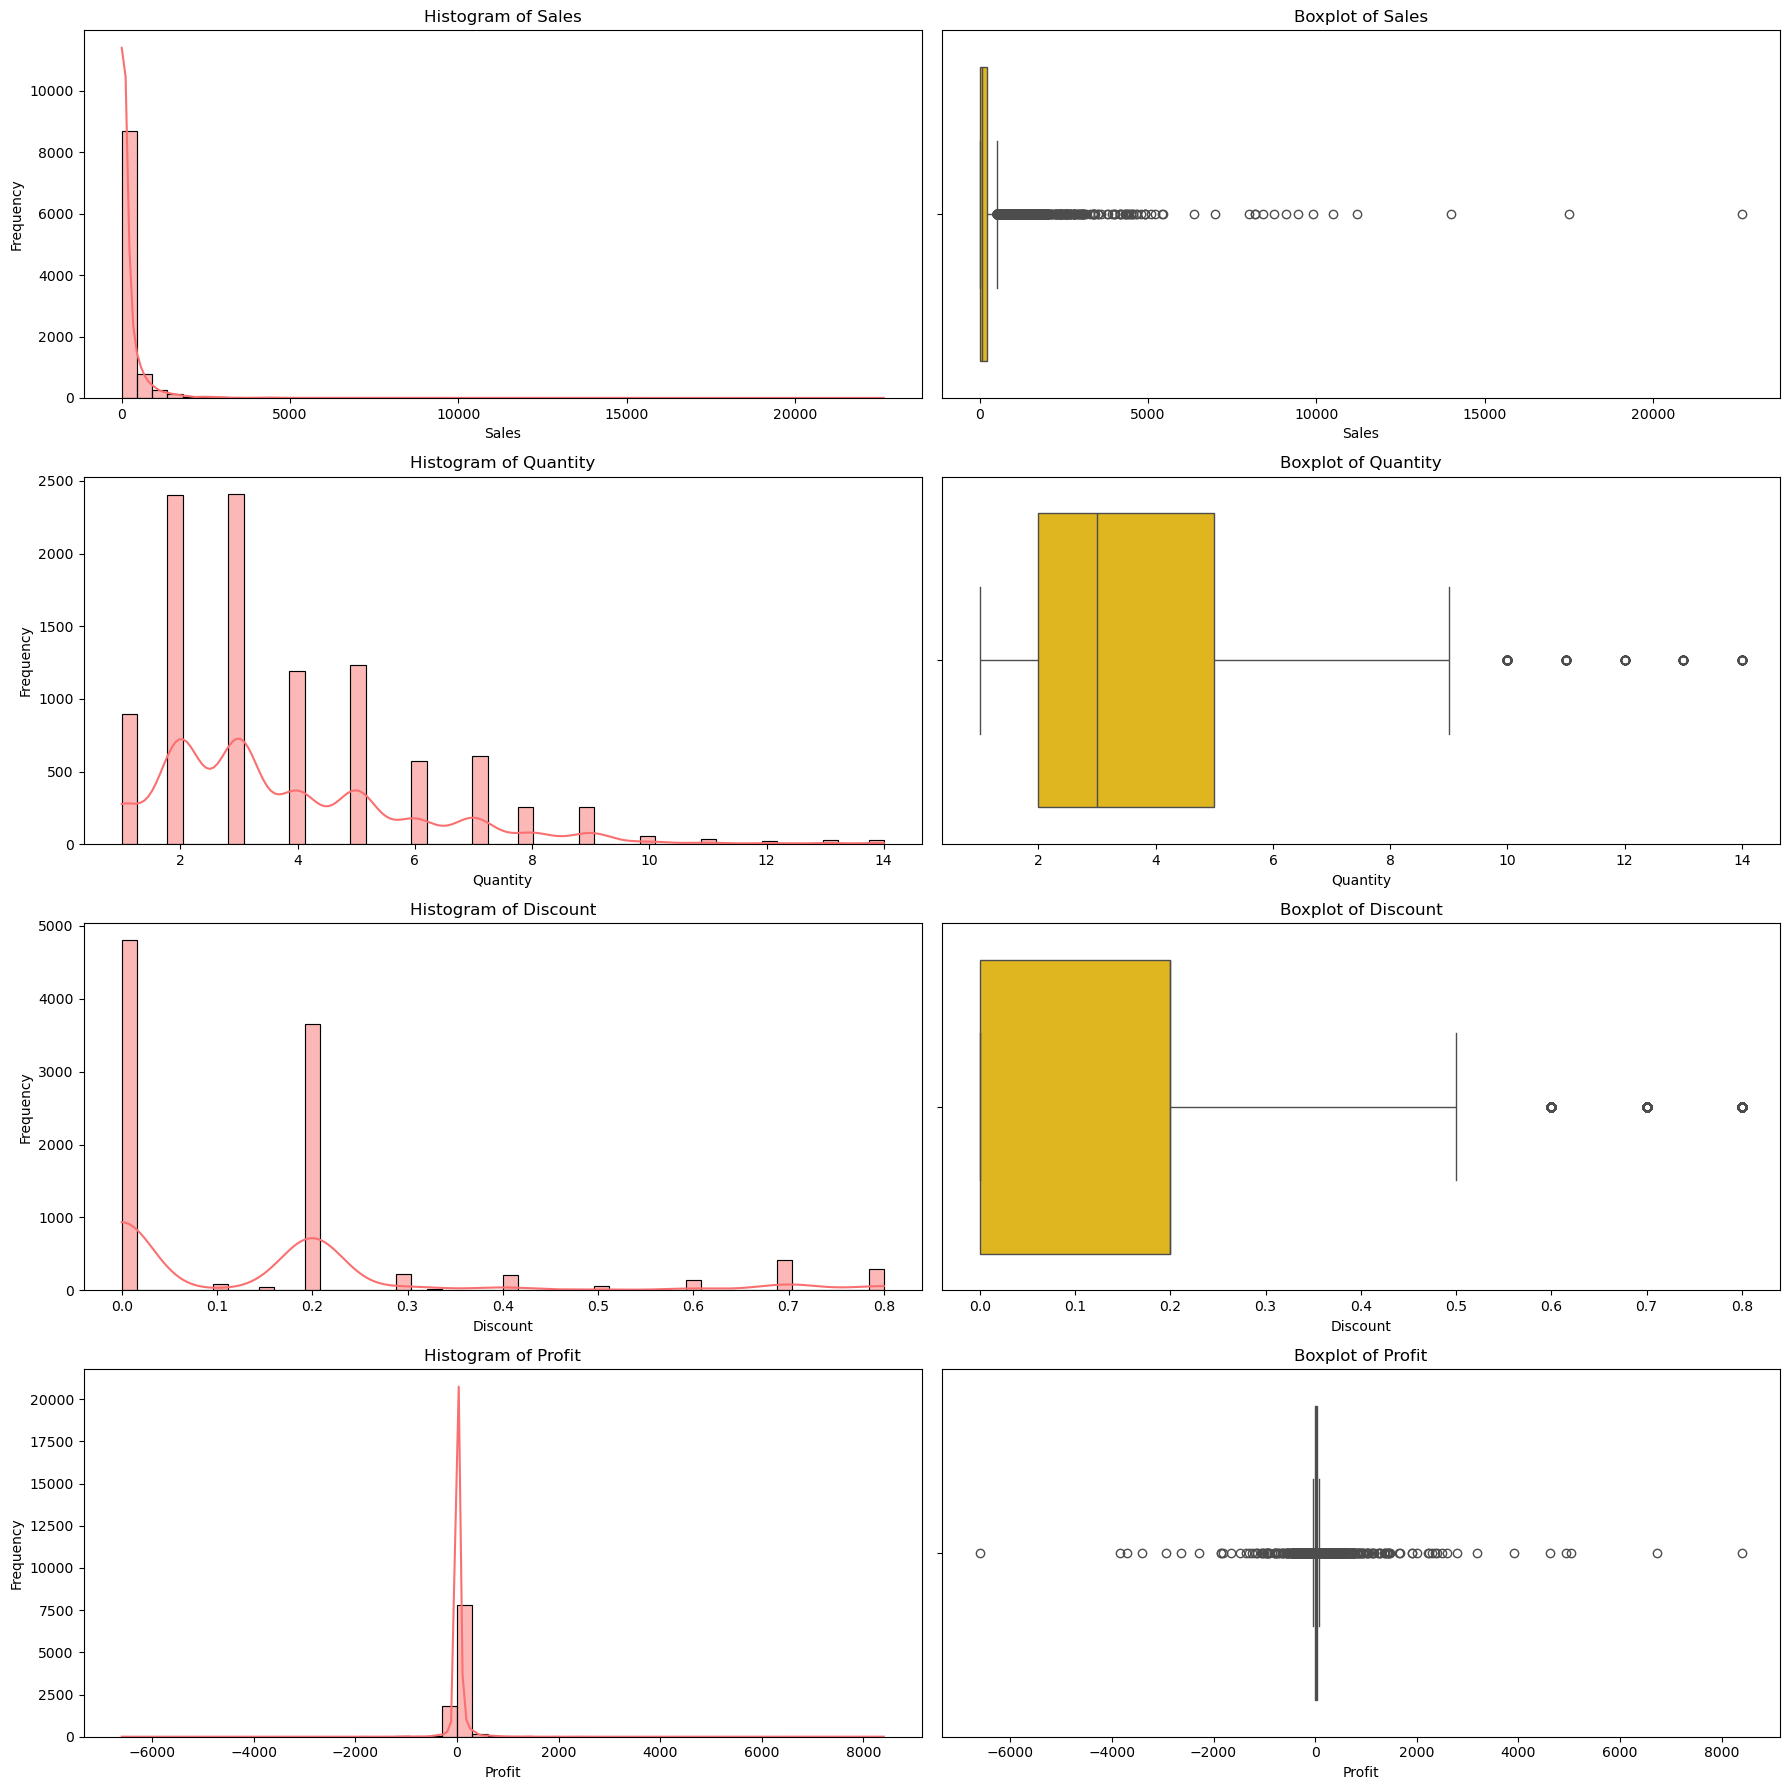

In [17]:
plt.figure(figsize=(18, 18))

for index, col in enumerate(numerical):
    # Histogram
    plt.subplot(len(numerical), 2, index * 2 + 1)
    sns.histplot(df[col], kde=True, color='#FA7070', bins=50)
    plt.title(f'Histogram of {col}', size=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(len(numerical), 2, index * 2 + 2)
    sns.boxplot(x=df[col], color='#FFC700')
    plt.title(f'Boxplot of {col}', size=12)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

Insight:
- Long Tail di Sales dan Profit: Penjualan dan keuntungan memiliki 'long tail', di mana nilai-nilai ekstrim sangat mempengaruhi rata-rata.
- Konsentrasi Diskon: Distribusi diskon menunjukkan bahwa ada konsentrasi yang kuat pada diskon tertentu, mungkin terkait dengan kebijakan penetapan harga atau promosi.
- Outliers: Kedua boxplot untuk penjualan dan keuntungan memiliki outliers yang signifikan, menunjukkan bahwa mungkin ada peluang untuk lebih memahami transaksi yang tidak tipikal ini.

### **Correlation**

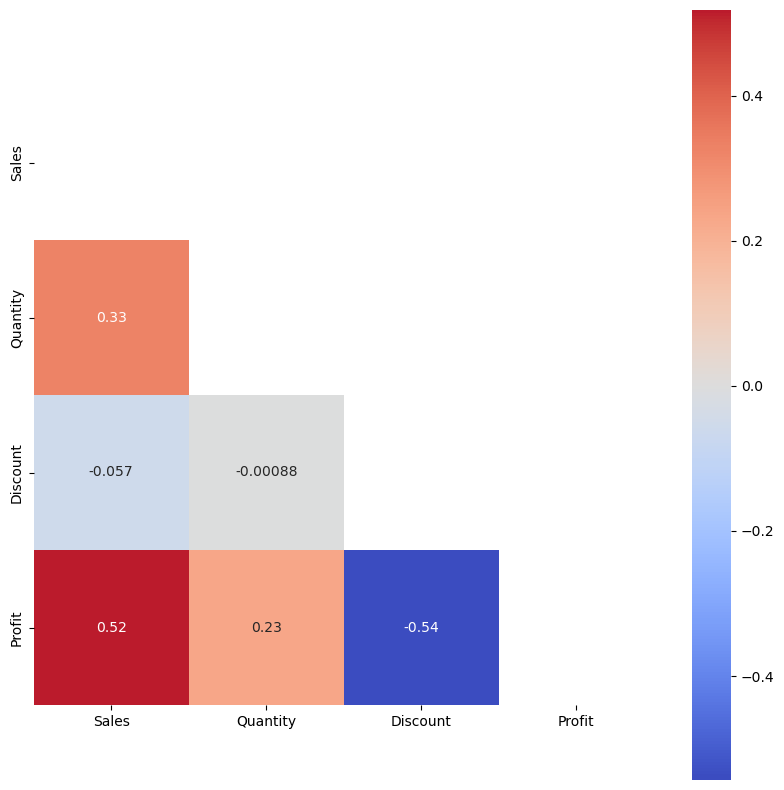

In [18]:
df_numeric = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = df_numeric.corr(method='spearman')

# Create a mask for the upper triangle
mask = np.triu(correlation_matrix)

# Create the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, mask=mask, square=True)
plt.show()

Dari matriks korelasi yang dihasilkan, terdapat beberapa insight:

| Value of Correlation Coeffficient | Relationship Interpretation |
| --- | --- |
| 0.000 - 0.199 | Very Weak |
| 0.200 - 0.399 | Weak |
| 0.400 - 0.599 | Moderate |
| 0.600 - 0.799 | Strong |
| 0.800 - 1.000 | Very Strong |

1. Korelasi antara 'Sales' dan 'Profit': +0.52
- Ada korelasi positif moderat antara 'Sales' dan 'Profit', yang mengindikasikan bahwa peningkatan penjualan cenderung diikuti dengan peningkatan keuntungan, meskipun hubungan ini tidak sempurna.
2. Korelasi antara 'Sales' dan 'Quantity': +0.33
- Hubungan positif lemah menunjukkan bahwa penjualan yang lebih tinggi cenderung memiliki jumlah barang yang lebih banyak, namun korelasi ini tidak terlalu kuat.
3. Korelasi antara 'Sales' dan 'Discount': −0.057
- Korelasi negatif yang sangat lemah, hampir tidak ada, menunjukkan bahwa diskon tidak secara signifikan mempengaruhi total penjualan secara langsung dalam dataset ini.
4. Korelasi antara 'Profit' dan 'Discount': −0.54
- Ada korelasi negatif moderat antara 'Profit' dan 'Discount', yang menunjukkan bahwa peningkatan diskon cenderung berkorelasi dengan penurunan keuntungan. Ini mengindikasikan bahwa walaupun diskon bisa meningkatkan jumlah penjualan dalam beberapa kasus, ini sering kali mengurangi margin keuntungan.
5. Korelasi antara 'Profit' dan 'Quantity': +0.23
- Hubungan positif yang sangat lemah, menunjukkan bahwa keuntungan tidak secara signifikan dipengaruhi oleh jumlah barang yang terjual per transaksi.
6. Korelasi antara 'Discount' dan 'Quantity': -0.00088
- Hubungan negatif yang sangat lemah, menunjukkan bahwa disocunt dapat mengurangi quantity, namun hampir tidak terjadi karena korelasinya hampir sama dengan 0

## **Categorical Features**

### **Distribusi**

In [19]:
categorical = [var for var in df.drop(columns=['Order ID', 'Order Date', 'Customer ID']).columns if df[var].dtypes == 'object']

In [20]:
categorical

['Contact Name',
 'Country',
 'City',
 'Region',
 'Subregion',
 'Customer',
 'Industry',
 'Segment',
 'Product']

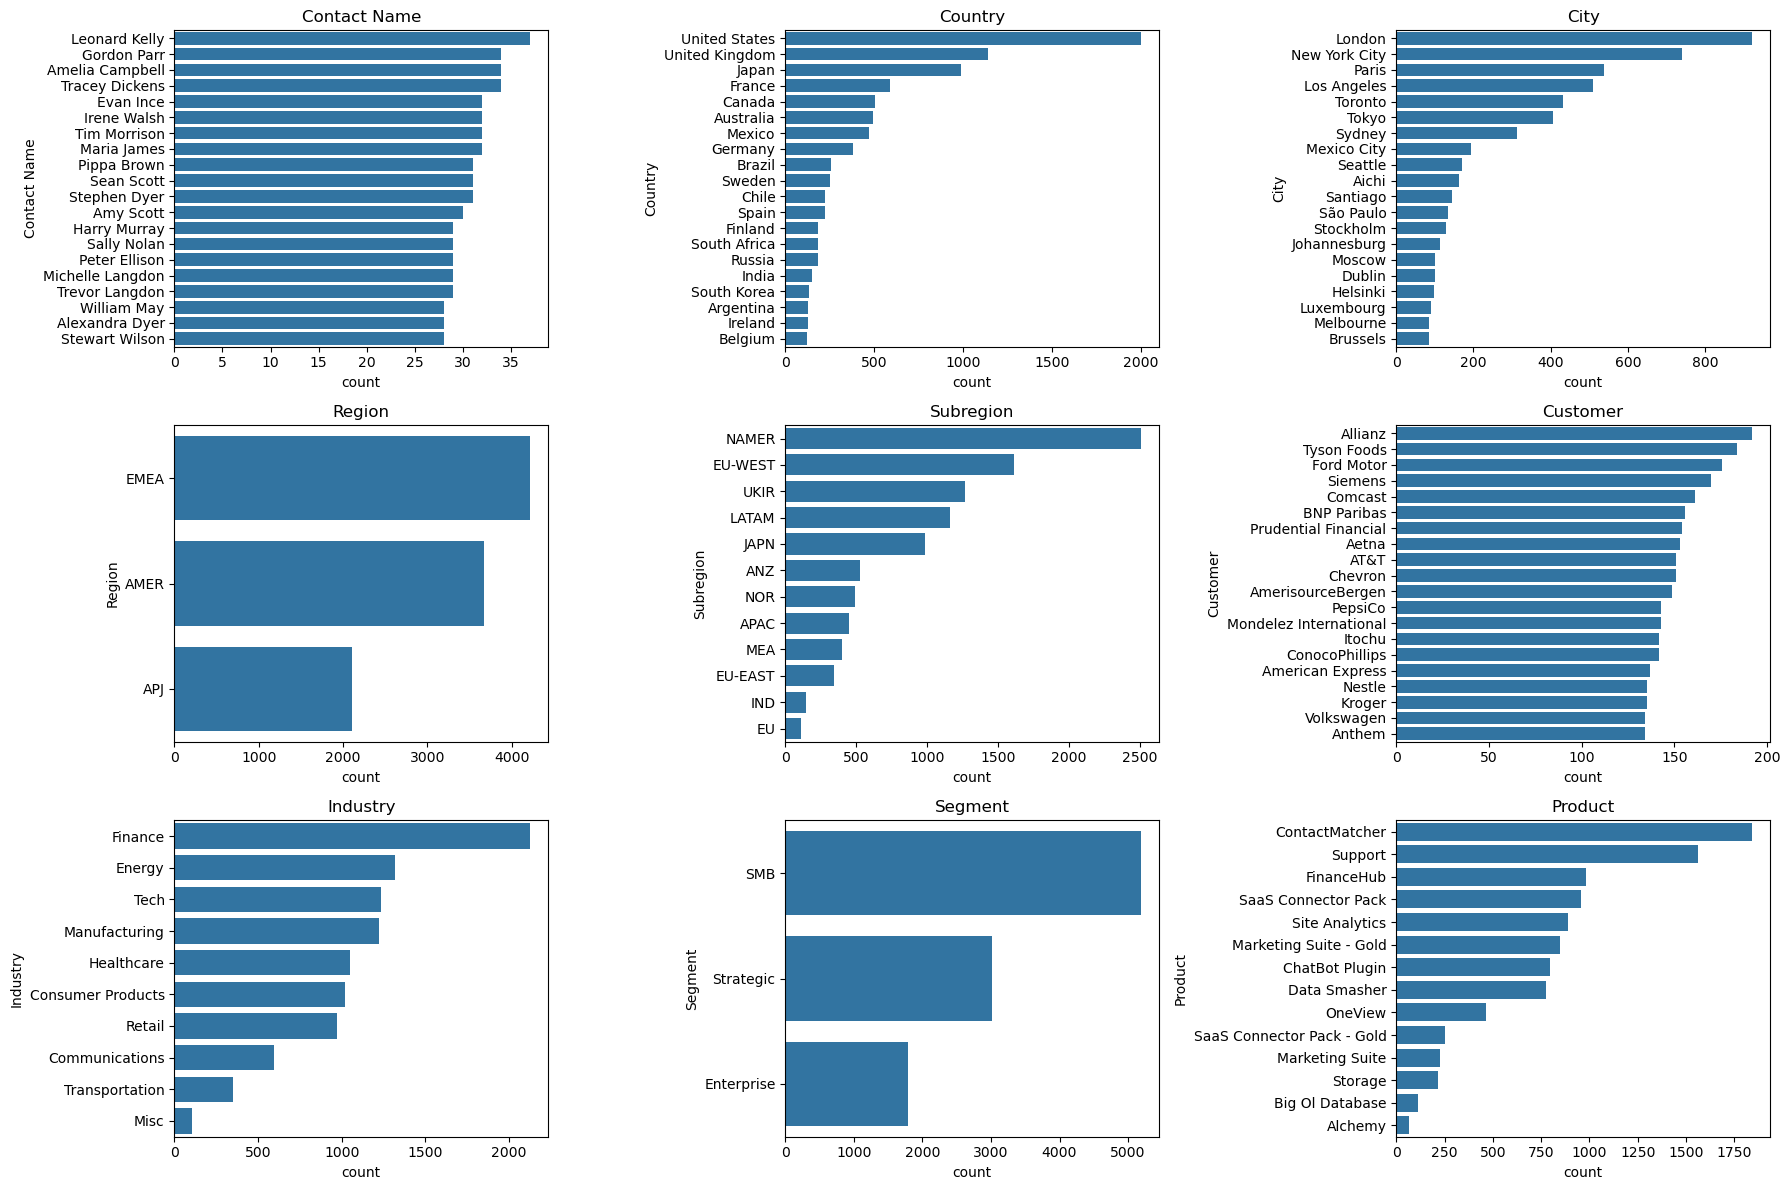

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, ax in zip(categorical, axes):
    # Get the top 20 categories based on their counts
    top_20_categories = df[i].value_counts().nlargest(20).index
    # Create a count plot for the top 20 categories only
    sns.countplot(data=df, y=i, ax=ax, order=top_20_categories)
    ax.set_title(f'{i}', size=12)

plt.tight_layout()
plt.show()


Insight Dari Top 20 Distribusi Categorical:
- Amerika Serikat unggul dalam jumlah transaksi, dengan Inggris di posisi kedua.
- London dan New York City mendominasi transaksi di tingkat kota.
- EMEA adalah region dengan transaksi terbanyak, dengan AMER mengikuti.
- Dalam hal industri, sektor Keuangan tampak paling banyak bertransaksi.
- Segmen 'SMB' adalah segment terbesar.
- Produk 'ContactMatcher' memiliki transaksi terbanyak.
- Customer dengan pembelian terbanyak adalah Allianz

# **Analisis**

## **Analisa Tren Penjualan dan Keuntungan**

### **Analisa Tren Penjualan**

In [22]:
trend_df = df.set_index('Order Date')

In [23]:
# Resampling data ke frekuensi bulanan untuk 'Sales' dan 'Profit'
annual_sales = trend_df['Sales'].resample('Y').sum()
monthly_sales = trend_df['Sales'].resample('M').sum()
annual_profit = trend_df['Profit'].resample('Y').sum()
monthly_profit = trend_df['Profit'].resample('M').sum()
monthly_quantity = trend_df['Quantity'].resample('M').sum()

#### `Annual Sales Trend`

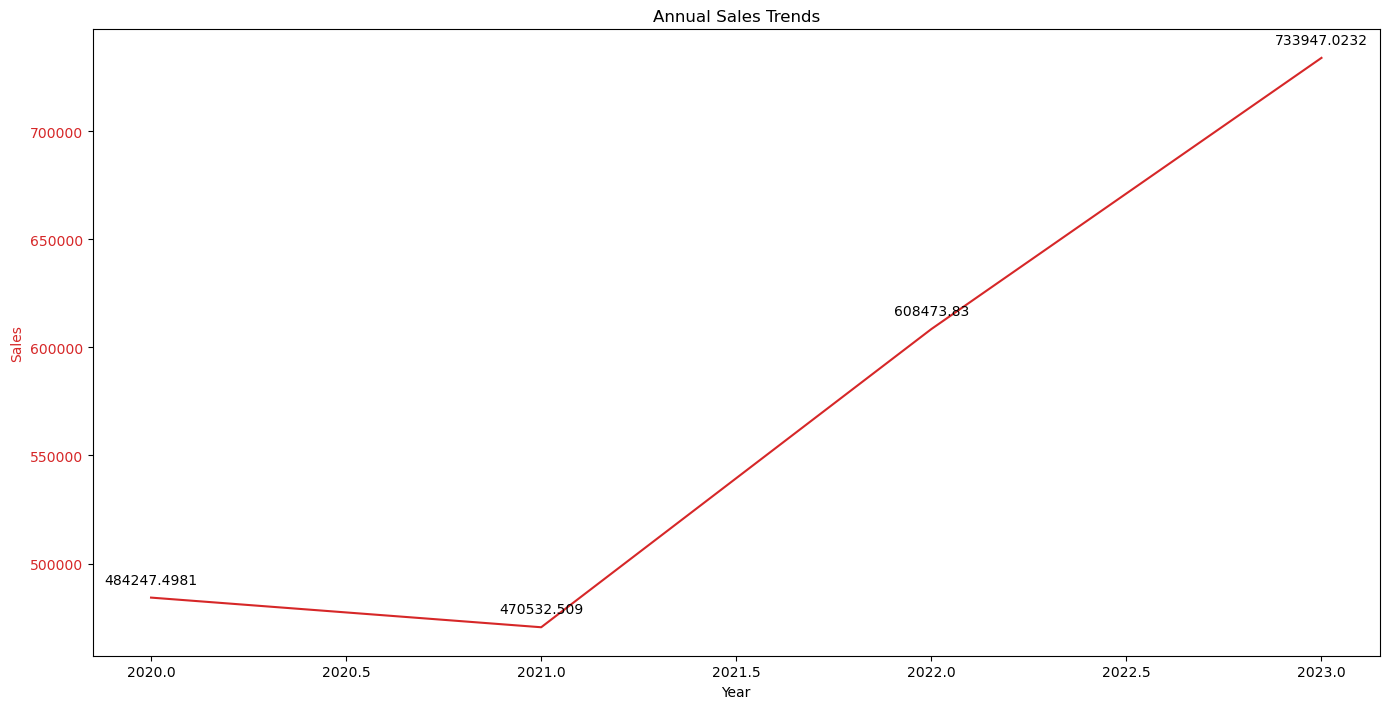

In [24]:
years = [2020, 2021, 2022, 2023]
fig, ax = plt.subplots(figsize=(14, 7))
color = 'tab:red'
ax.set_xlabel('Year')
ax.set_ylabel('Sales', color=color)
ax.plot(years, annual_sales, color=color)
ax.tick_params(axis='y', labelcolor=color)

# Annotating each point with its value
for i, txt in enumerate(annual_sales):
    ax.annotate(txt, (years[i], annual_sales[i]), textcoords="offset points", xytext=(0,10), ha='center')

fig.tight_layout()
plt.title('Annual Sales Trends')
plt.show()

Insight:
1. Tren Meningkat: Terlihat jelas ada kecenderungan penjualan yang meningkat dari tahun ke tahun. Penjualan terus bertambah setiap tahunnya, hanya saja sempat mengalami penurun penjualan pada tahun 2021 sebanyak 13.714 USD, tren ini merupakan sinyal positif bagi bisnis perusahaan, mengindikasikan pertumbuhan.
2. Pertumbuhan Stabil: Pertumbuhan tampaknya cukup stabil dan linier, yang menunjukkan kenaikan penjualan yang konsisten daripada lonjakan tiba-tiba. Ini bisa berarti bahwa strategi pertumbuhan perusahaan efektif dan berkelanjutan.

Insight:
1. Fluktuasi Bulanan: 
- Fluktuasi penjualan bulanan terlihat cukup jelas, dengan puncak tertinggi sering muncul di bulan September dan November, yang bisa menunjukkan adanya periode penjualan kuat yang mungkin berkaitan dengan faktor-faktor musiman seperti kampanye pemasaran atau kebiasaan belanja pelanggan.
- Bulan-bulan seperti Februari sering menunjukkan angka penjualan yang lebih rendah, yang bisa mengindikasikan adanya periode lesu pasca-liburan atau faktor lain yang mempengaruhi anggaran belanja pelanggan.

##### `Monthly Sales Trend`

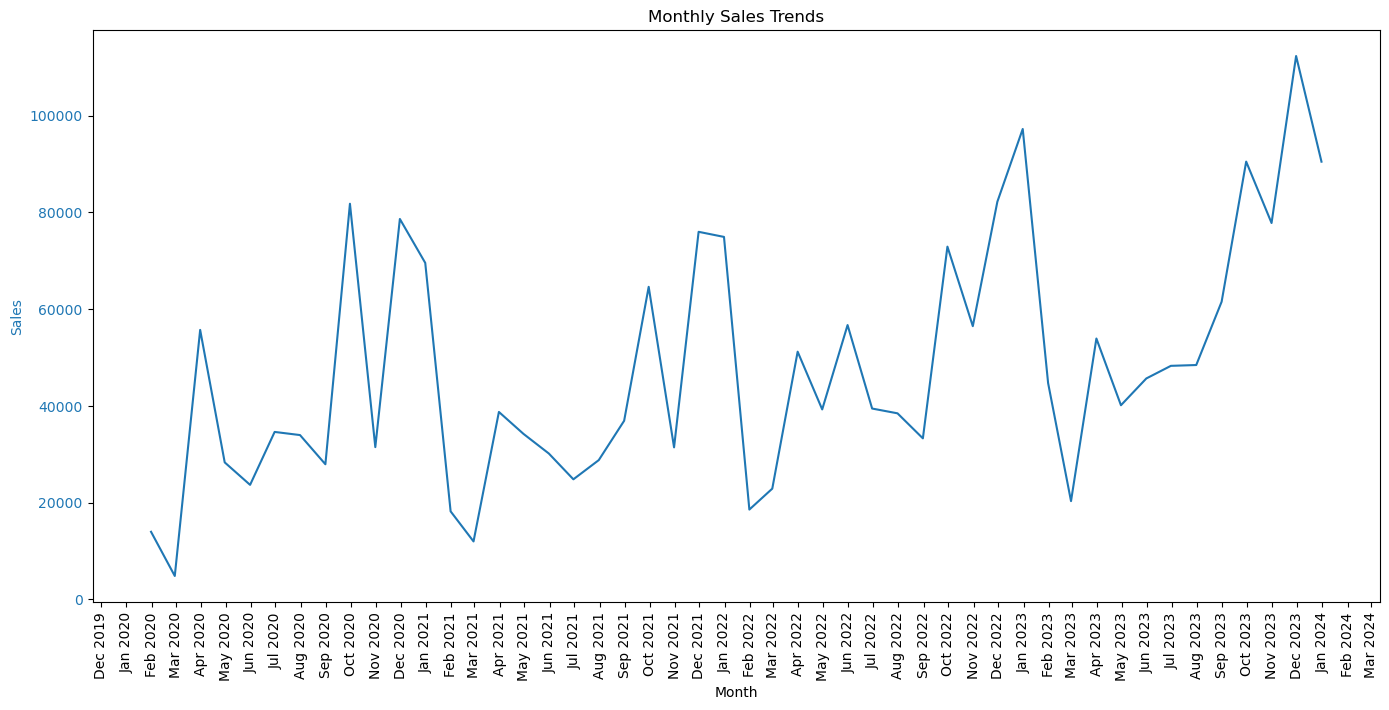

In [25]:
fig, ax = plt.subplots(figsize=(14, 7))
color = 'tab:blue'
ax.set_xlabel('Month')
ax.set_ylabel('Sales', color=color)
ax.plot(monthly_sales.index, monthly_sales, color=color)
ax.tick_params(axis='y', labelcolor=color)

# Set format untuk sumbu x menjadi nama bulan dan tahun.
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Untuk menandai setiap bulan.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format bulan dan tahun.

# Rotasi label sumbu x agar mudah dibaca.
plt.xticks(rotation=90)

# Atur layout agar tidak ada label yang terpotong.
fig.tight_layout() 

plt.title('Monthly Sales Trends')
plt.show()

Insight:
- Fluktuasi Musiman: Grafik menunjukkan adanya fluktuasi bulanan yang bisa mengindikasikan tren musiman dalam penjualan. Misalnya, mungkin ada bulan-bulan tertentu dengan penjualan yang lebih tinggi, yang bisa dikaitkan dengan peristiwa atau musim tertentu (seperti hari raya atau musim liburan).
- Pertumbuhan Jangka Panjang: Meskipun ada fluktuasi bulanan, terdapat tren peningkatan penjualan dari tahun 2020 hingga 2023, yang menunjukkan pertumbuhan jangka panjang.

#### `Annual Profit Trends`

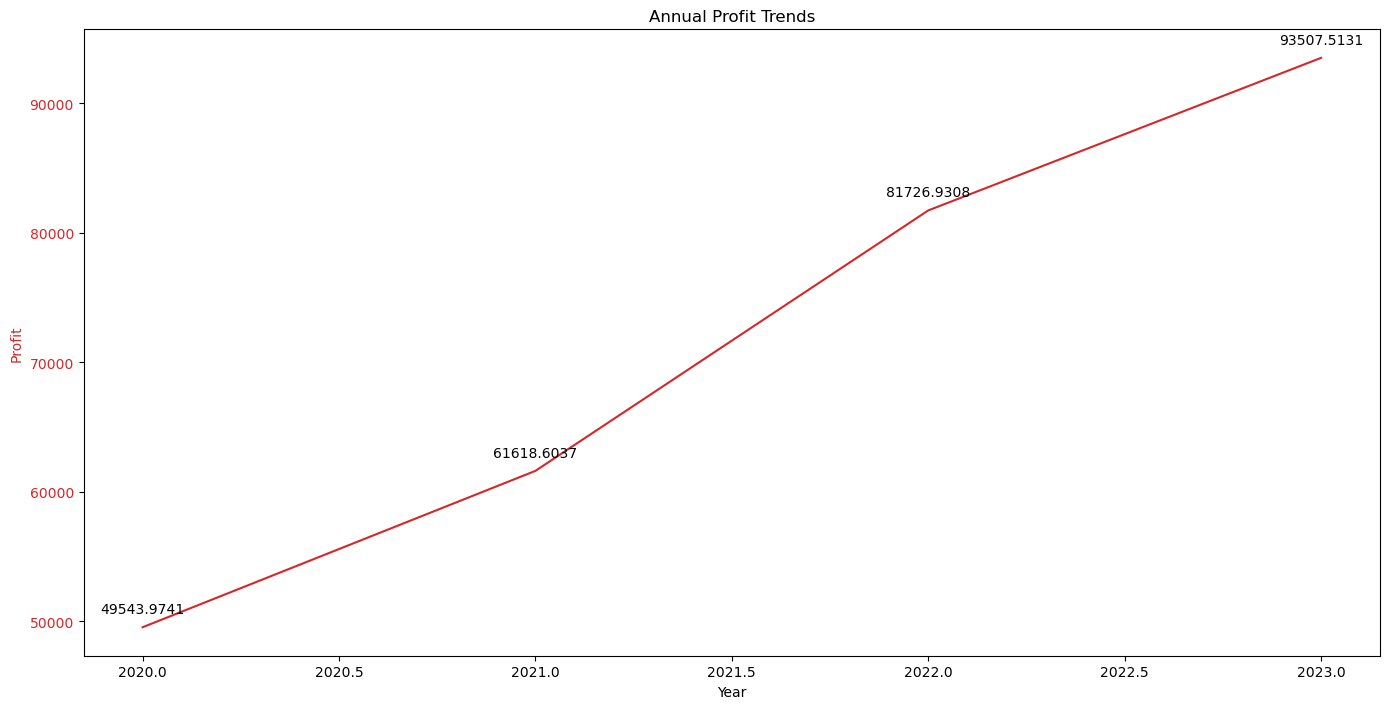

In [26]:
years = [2020, 2021, 2022, 2023]
fig, ax = plt.subplots(figsize=(14, 7))
color = 'tab:red'
ax.set_xlabel('Year')
ax.set_ylabel('Profit', color=color)
ax.plot(years, annual_profit, color=color)
ax.tick_params(axis='y', labelcolor=color)

# Annotating each point with its value
for i, txt in enumerate(annual_profit):
    ax.annotate(txt, (years[i], annual_profit[i]), textcoords="offset points", xytext=(0,10), ha='center')

fig.tight_layout()
plt.title('Annual Profit Trends')
plt.show()

Insight:
- Pertumbuhan Keuntungan: Ada tren pertumbuhan keuntungan yang konsisten dari tahun ke tahun. Ini menandakan performa keuangan yang positif selama periode tersebut.
- Tren Naik yang Stabil: Garis tren menunjukkan pertumbuhan yang stabil tanpa fluktuasi besar, yang mungkin mengindikasikan pengelolaan bisnis yang baik dan strategi pertumbuhan yang efektif.

#### `Monthly Profit Trends`

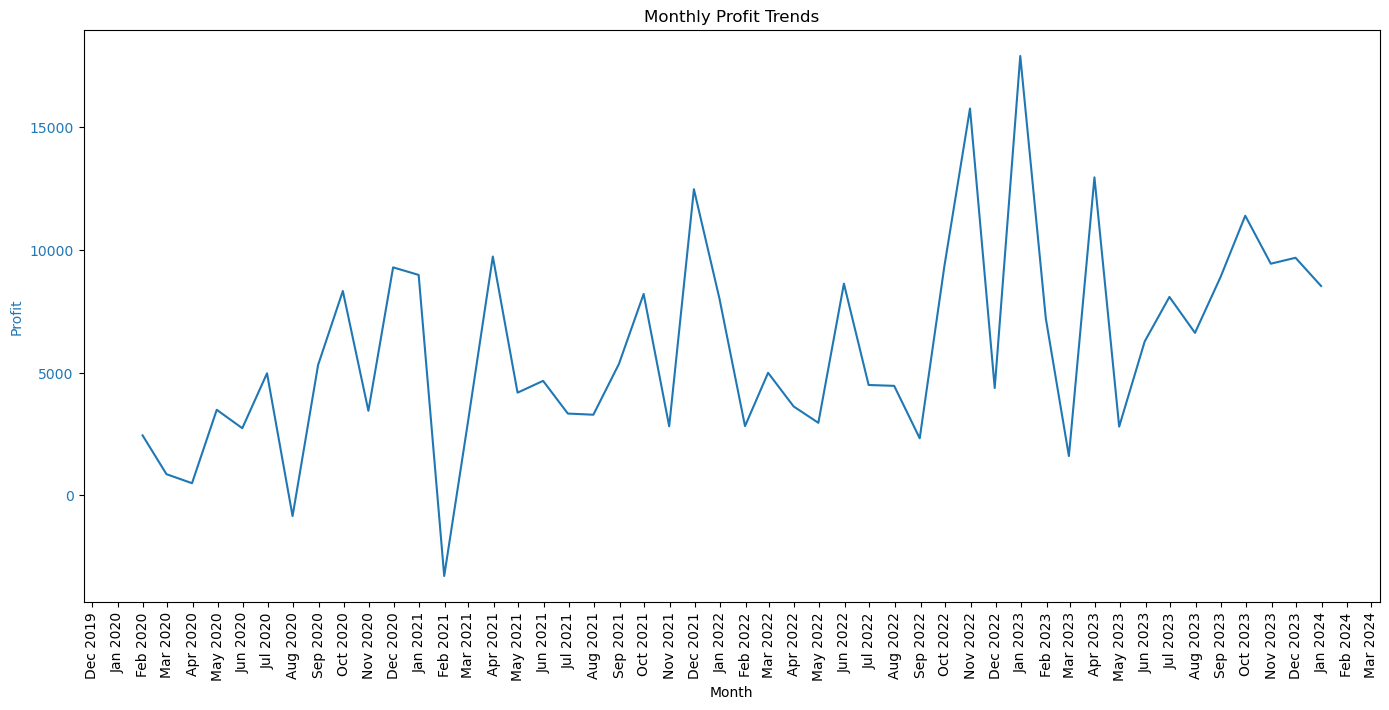

In [27]:
fig, ax = plt.subplots(figsize=(14, 7))
color = 'tab:blue'
ax.set_xlabel('Month')
ax.set_ylabel('Profit', color=color)
ax.plot(monthly_profit.index, monthly_profit, color=color)
ax.tick_params(axis='y', labelcolor=color)

# Set format untuk sumbu x menjadi nama bulan dan tahun.
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Untuk menandai setiap bulan.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format bulan dan tahun.

# Rotasi label sumbu x agar mudah dibaca.
plt.xticks(rotation=90)

# Atur layout agar tidak ada label yang terpotong.
fig.tight_layout() 

plt.title('Monthly Profit Trends')
plt.show()

Insight:
- Fluktuasi Bulanan: Grafik menunjukkan fluktuasi yang signifikan dalam profit dari bulan ke bulan. Ini bisa mengindikasikan bahwa ada beberapa faktor musiman atau kejadian tertentu yang mempengaruhi profitabilitas dari waktu ke waktu.
- Pola Tidak Teratur: Tidak adanya pola yang konsisten menunjukkan bahwa profit bisa dipengaruhi oleh banyak variabel dan mungkin sulit untuk diprediksi hanya dengan data ini saja.

#### **Kesimpulan**
- Penjualan dan Profit memiliki trend tahunan pertumbuhan yang stabil
- Penjualan memiliki trend bulanan yang selalu naik di akhir tahun dan cenderung turun di awal tahun, hal ini bisa disebabkan perilaku konsumen.
- Profit tidak memiliki trend bulanan yang jelas seperti trend bulanan penjualan, hal ini bisa disebabkan beberapa faktor perilaku konsumen. Maka dari itu perlu ada analisa lebih lanjut menggunakan pengaruh diskon untuk melihat apakah ada pengaruhnya terhadap penjualan produk

## **Analisa Customer Paling Berharga**
Analisa ini akan melakukan pengelompokan customer berdasarkan RFM Analysis yang dimana akan dilakukan pembototan pada setiap unik customer berdasarkan Recenecy(Pembelian Terakhir), Frequency(Jumlah Transaksi), dan Monetary(Jumlah Pengeluaran). Kolom yang dipakai dalam analisa ini meliputi:
- Order ID: Digunakan untuk menghitung frekuensi pembelian.
- Order Date: Digunakan untuk menghitung recency, yaitu seberapa baru transaksi terakhir.
- Customer ID: Digunakan untuk mengidentifikasi pelanggan unik.
- Sales: Digunakan untuk menghitung nilai moneter dari transaksi.

In [28]:
latest_date = df['Order Date'].max()

# Calculating Recency, Frequency, and Monetary values for each customer
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (latest_date - x.max()).days,  # Recency
    'Order ID': 'nunique',                                 # Frequency
    'Sales': 'sum'                                         # Monetary
}).rename(columns={
    'Order Date': 'Recency',
    'Order ID': 'Frequency',
    'Sales': 'Monetary'
})

rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
1001,12,31,12617.1140
1002,21,76,27278.5930
1003,1,61,39941.6400
1004,13,62,23189.2165
1005,7,71,33514.9210


RFM Analysis yang dilakukan menggunakan pendekatan quartiles untuk menetapkan skor dari 1 hingga 4 untuk setiap aspek RFM:

- Recency: Skor lebih rendah berarti lebih baik, jadi pelanggan yang baru-baru ini membeli akan mendapat skor yang lebih rendah.
- Frequency dan Monetary: Skor lebih tinggi berarti lebih baik, jadi frekuensi yang lebih tinggi dan pengeluaran yang lebih besar akan mendapat skor yang lebih tinggi.

Berikut adalah pelanggan yang telah diberikan skor RFM berdasarkan quartiles untuk Recency, Frequency, dan Monetary:


In [29]:
# Calculate quartiles
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

# Assigning scores
rfm['R_score'] = rfm['Recency'].apply(R_score, args=('Recency', quantiles,))
rfm['F_score'] = rfm['Frequency'].apply(FM_score, args=('Frequency', quantiles,))
rfm['M_score'] = rfm['Monetary'].apply(FM_score, args=('Monetary', quantiles,))

# Combine the RFM score
rfm['RFM_Score'] = rfm['R_score'].map(str) + rfm['F_score'].map(str) + rfm['M_score'].map(str)

rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
Customer ID,,,,,,,
1001,12,31,12617.1140,2,1,1,211
1002,21,76,27278.5930,2,4,3,243
1003,1,61,39941.6400,4,4,4,444
1004,13,62,23189.2165,2,4,3,243
1005,7,71,33514.9210,3,4,4,344


Mengklasifikasikan pelanggan berdasarkan skor RFM mereka dan melabeli mereka dengan kategori ini. Berikut adalah penjelasan dari setiap label yang dibuat:
1. Champions
- Recency: Pelanggan yang pembelian terakhirnya termasuk dalam kuartil teratas (misalnya, Recency score 4).
- Frequency: Frekuensi pembelian dalam kuartil teratas (misalnya, Frequency score 4).
- Monetary: Jumlah uang yang dihabiskan juga dalam kuartil teratas (misalnya, Monetary score 4).
2. Loyal Customers
- Frequency: Frekuensi pembelian tinggi (Frequency score 3 atau 4).
- Monetary: Jumlah uang yang dihabiskan tinggi (Monetary score 3 atau 4).
- Recency: Pembelian terakhir bisa jadi tidak sebaru Champions tetapi masih cukup baru (Recency score 2 atau lebih).
3. Potential Loyalist
- Recency: Baru-baru ini telah melakukan pembelian (Recency score 3 atau 4).
- Frequency: Frekuensi pembelian moderat (Frequency score 2 atau 3).
- Monetary: Jumlah uang yang dihabiskan moderat atau tinggi (Monetary score 2 atau lebih).
4. New Customers
- Recency: Pembelian sangat baru (Recency score 4).
- Frequency: Frekuensi pembelian rendah (Frequency score 1).
- Monetary: Jumlah uang yang dihabiskan rendah (Monetary score 1).
5. At Risk
- Recency: Sudah cukup lama tidak melakukan pembelian (Recency score 1 atau 2).
- Frequency: Dulunya sering melakukan pembelian (Frequency score 3 atau 4).
- Monetary: Jumlah uang yang dihabiskan bisa jadi tinggi (Monetary score 2 atau lebih).
6. Can’t Lose Them
- Recency: Sudah sangat lama tidak melakukan pembelian (Recency score 1).
- Frequency: Frekuensi pembelian mungkin moderat (Frequency score 1 atau 2).
- Monetary: Jumlah uang yang dihabiskan tinggi (Monetary score 3 atau 4).
7. Hibernating
- Recency: Sangat lama tidak melakukan pembelian (Recency score 1).
- Frequency: Frekuensi pembelian rendah (Frequency score 1 atau 2).
- Monetary: Jumlah uang yang dihabiskan rendah (Monetary score 1 atau 2).

In [30]:
rfm['Customer Segment'] = rfm.apply(label_customer, axis=1)
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Customer Segment
Customer ID,,,,,,,,
1001,12,31,12617.1140,2,1,1,211,Hibernating
1002,21,76,27278.5930,2,4,3,243,Loyal Customers
1003,1,61,39941.6400,4,4,4,444,Champions
1004,13,62,23189.2165,2,4,3,243,Loyal Customers
1005,7,71,33514.9210,3,4,4,344,Loyal Customers


Dengan segmentasi RFM ini dapat dikembangkan menjadi strategi pemasaran dan interaksi yang lebih spesifik untuk masing-masing segmen pelanggan. Berikut beberapa langkah yang dapat Anda ambil berikutnya:

1. Champions: 
- Menawarkan penghargaan eksklusif, akses pertama ke produk baru, dan undangan ke event khusus. Pertimbangkan juga program referral karena pelanggan ini cenderung menjadi advokat merek yang baik.
- Tujuan: Mempertahankan loyalitas mereka dan mendorong lebih banyak pembelian.
2. Loyal Customers: 
- Mengirimkan email atau notifikasi teratur tentang penawaran khusus dan produk baru yang sesuai dengan minat mereka. Program loyalitas dengan poin dan hadiah bisa sangat efektif.
- Tujuan: Menumbuhkan mereka menjadi Champions.
3. Potential Loyalist:
- Menyediakan penawaran khusus seperti diskon pada pembelian kedua  untuk meningkatkan frekuensi pembelian mereka.
- Tujuan: Mengubah pelanggan baru menjadi pembeli reguler dan loyal.
4. At Risk dan Can’t Lose Them:
- Mengidentifikasi alasan mereka berhenti berbelanja atau berkurangnya minat. Tawarkan produk atau layanan yang sangat relevan untuk memulihkan minat mereka. Survei dapat membantu mengidentifikasi masalahnya.
- Tujuan: Mencegah mereka beralih ke pesaing dan memulihkan aktivitas pembelian mereka.
5. Hibernating:
- Mengirimkan penawaran yang tidak bisa ditolak atau kampanye email untuk mendorong pembelian kembali.
- Tujuan: Membangkitkan kembali hubungan dengan mereka.
6. New Customers:
- Menyambut mereka dengan paket orientasi yang meliputi panduan produk, kupon diskon untuk pembelian berikutnya, dan ajakan untuk mengikuti media sosial atau newsletter Anda.
- Tujuan: Membuat kesan pertama yang kuat dan mendorong loyalitas dari awal.


`Alat dan Implementasi`
- Menggunakan perangkat lunak manajemen hubungan pelanggan (CRM) untuk melacak interaksi dan perilaku pelanggan, dan gunakan alat otomasi pemasaran untuk mengirimkan pesan yang relevan dan tepat waktu berdasarkan segmentasi ini.
- Analisis Data Berkelanjutan: Selalu ukur respons dari kampanye yang dilakukan. Analisis yang berkelanjutan akan membantu menyempurnakan pendekatan dan memahami ROI dari berbagai inisiatif.

In [31]:
rfm.reset_index(inplace=True)

Setelah melabeli customer pada tabel rfm, selanjutnya label tersebut akan digabungkan pada tabel utama, hal tersebut dilakukan untuk dapat melakukan analisa lebih lanjut menggunakan Customer Segment.

In [32]:
df = df.merge(rfm[['Customer ID', 'Customer Segment']], on='Customer ID', how='left')

Menampilkan customer paling berharaga bagi perusahaan:

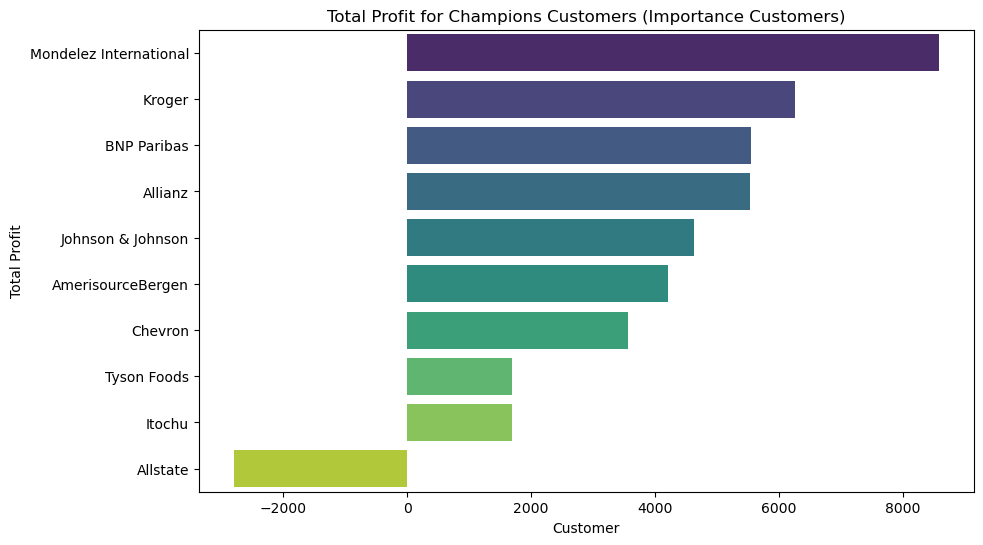

In [33]:
champions_profit = df[df['Customer Segment']=='Champions'].groupby('Customer')['Profit'].sum().sort_values(ascending=False)

# Buat bar plot
plt.figure(figsize=(10, 6))
sns.barplot(y=champions_profit.index, x=champions_profit.values, order=champions_profit.index, palette='viridis')
plt.title('Total Profit for Champions Customers (Importance Customers)')
plt.xlabel('Customer')
plt.ylabel('Total Profit')
plt.xticks(rotation=0)
plt.show()

In [34]:
display(df[df['Customer Segment']=='Champions'].groupby(['Customer'])['Profit'].sum().sort_values(ascending=False))

Customer
Mondelez International    8577.6524
Kroger                    6256.1005
BNP Paribas               5550.8063
Allianz                   5531.8834
Johnson & Johnson         4632.4593
AmerisourceBergen         4202.8824
Chevron                   3569.8980
Tyson Foods               1690.5775
Itochu                    1690.4793
Allstate                 -2796.2935
Name: Profit, dtype: float64

Insight:
- Meskipun Customer tersebut sudah dikategorikan sebagai 'Champions' tetapi perlu ada beberapa hal yang diperhatikan, diantaranya adalah:
1. Konsentrasi Pendapatan: Sebagian besar profit tampaknya dihasilkan oleh beberapa pelanggan teratas, menandakan bahwa perusahaan mungkin sangat bergantung pada pendapatan dari sekelompok kecil pelanggan. Perusahaan perlu memastikan hubungan ini dipertahankan sambil juga berupaya untuk mengembangkan basis pelanggan yang lebih luas untuk mengurangi risiko.
2. Evaluasi Hubungan Pelanggan: Variasi profit yang luas dalam segmen Champions menyarankan bahwa perusahaan mungkin perlu menyesuaikan tingkat layanan dan personalisasi tawaran untuk masing-masing pelanggan, dengan tujuan untuk meningkatkan kepuasan dan profitabilitas pelanggan secara individual.
3. Oportunis Khusus untuk Perbaikan: Khusus untuk Allstate, perusahaan harus melakukan penyelidikan untuk mengidentifikasi mengapa hubungan ini tidak menguntungkan dan mengeksplorasi strategi untuk mengubah kerugian menjadi keuntungan, apakah itu melalui renegosiasi kontrak, perbaikan layanan, atau penawaran yang lebih menarik.

## **Analisa Faktor Yang Mempengaruhi Keuntungan**
Analisa ini akan melakukan beberapa analisa, diantaranya adalah:
1. Apakah diskon berpengaruh terhadap keuntungan?
2. Apakah region berpengaruh terhadap keuntungan?
3. Apakah segmen berpengaruh terhadap keuntungan?
4. Apakah industri berpengaruh terhadap keuntungan?


### **Analisa Pengaruh Diskon Terhadap Keuntungan**

Berdasarkan tabel korelasi antara fitur numerikal yang sudah dibuat pada tahapan EDA, telah diketahui bahwa discount memiliki korelasi sebesar:
1. Discount - Profit (korelasi negatif moderat 0.54) 
2. Discount - Sales (korelasi negatif sangat lemah -0.05)
3. Discount - Quantity (korelasi negatif sangat lemah -0.00088)

Hal ini menunjukan bahwa discount yang telah dibuat malah membuat perusahaan rugi dari ketiga aspek tersebut (Profit, Sales, dan Quantity). Strategi discount yang kurang baik perlu dibenahi agar perusahaan tetap mendapat manfaat setelah mengaplikasikan discount pada produknya.

#### `Creating New Column`

Untuk menganalisa lebih lanjut pengaruh diskon terhadap keuntungan perusahaan, maka diperlukan untuk mengetahui Harga Pokok Produk(COGS) pada setiap transaksi, sehingga dapat mengetahui harga sebelumnya, hal tersebut dilakukan untuk mendapat nilai profit perusahaan yang seharusnya mereka dapat sebelum diskon

In [35]:
df['COGS'] = df['Sales'] - df['Profit']
df['Profit Bef Disc'] = df['Profit'] + (df['Sales']*df['Discount'])

Text(0.5, 1.0, 'Before & After Discount')

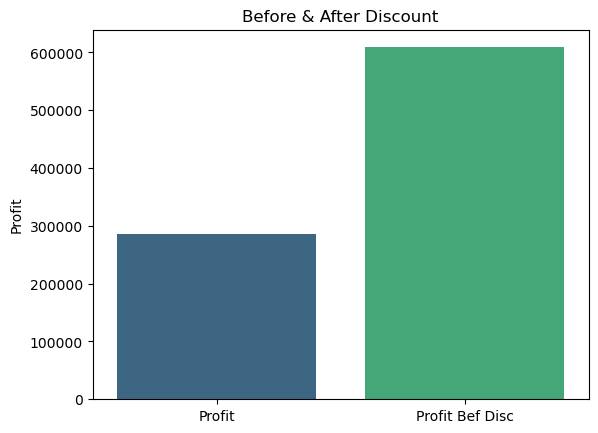

In [36]:
profit_sum = df[['Profit', 'Profit Bef Disc']].sum()

ax = sns.barplot(x=profit_sum.index, y=profit_sum.values, palette='viridis')

ax.set_ylabel('Profit')
ax.set_xlabel('')
ax.set_title('Before & After Discount')

In [37]:
profit_now = df['Profit'].sum()
profit_before = df['Profit Bef Disc'].sum()
print(f"Keuntungan perusahaan sesudah discount sebesar {profit_now} USD")
print(f"Keuntungan perusahaan sebelum discount sebesar {profit_before} USD")
print(f"Keuntungan perusahaan setelah discount berkurang sebanyak {profit_before-profit_now} USD")

Keuntungan perusahaan sesudah discount sebesar 286397.0217 USD
Keuntungan perusahaan sebelum discount sebesar 608979.156041 USD
Keuntungan perusahaan setelah discount berkurang sebanyak 322582.13434100006 USD


Insight:
- Perusahaan akan mendapatkan keuntungan sebesar 608979 USD yang dimana itu sebanyak 2 kali lipat jika tidak melakukan discount, hal ini dapat diperkuat karena saat melihat korelasi memang discount berkorelasi negatif sebesar 0.54 terhadap keuntungan.
- Perusahaan sebaiknya meninjau ulang dalam pemberian discount pada produknya.

#### Pengaruh Kelompok Diskon Terhadap Keuntungan

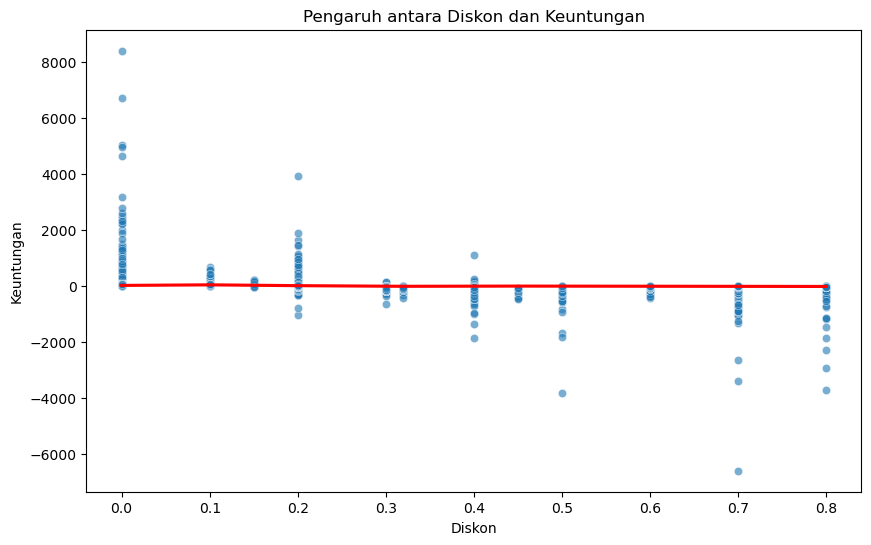

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Discount', y='Profit', data=df, alpha=0.6)
sns.regplot(x='Discount', y='Profit', data=df, scatter=False, lowess=True, color='red')  # Lowess untuk smoothing trend line
plt.title('Pengaruh antara Diskon dan Keuntungan')
plt.xlabel('Diskon')
plt.ylabel('Keuntungan')
plt.show()

Insight:
Terlihat bahwa semakin besar diskon yang diberikan, keuntungan cenderung menurun

### **Analisa Pnegaruh Region Terhadap Keuntungan**
Setiap region memiliki keuntungan yang berbeda, oleh karena itu perlu dilakukan analisis untuk mengetahui apakah region itu berpengaruh terhadap keuntungan

In [39]:
region_profit = df.groupby('Region')['Profit'].sum().sort_values().reset_index()
region_profit

,Region,Profit
0,APJ,11513.9869
1,AMER,127426.9898
2,EMEA,147456.0450


Text(0.5, 1.0, 'Keuntungan Transaksi Setiap Region')

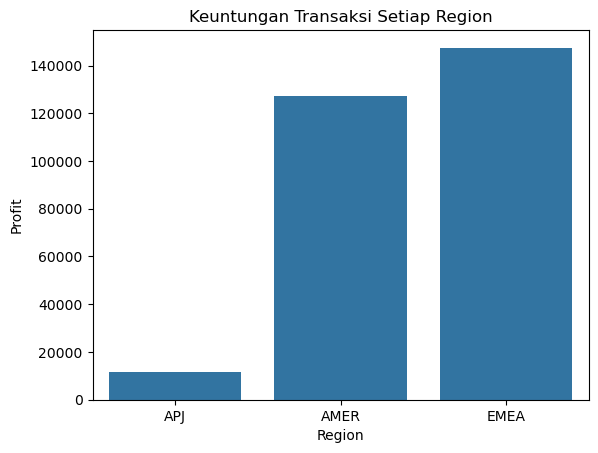

In [40]:
sns.barplot(data=region_profit, x='Region', y='Profit')
plt.title('Keuntungan Transaksi Setiap Region')  # Perbaikan pengetikan di sini

Insight:
- Region EMEA tampaknya menghasilkan keuntungan paling tinggi dari transaksi yang dilakukan, diikuti oleh region AMER.
- AMER memiliki keuntungan yang signifikan dari transaksi tetapi tidak sebanyak EMEA.
- Region APj menunjukkan keuntungan yang jauh lebih rendah dibandingkan dua region lainnya.

 `Uji Statistik`
 
 Hipotesis Nol (H0) untuk Setiap Uji:

 Region: Tidak ada perbedaan signifikan dalam keuntungan antar kelompok region yang berbeda.

In [41]:
region_groups = [df['Profit'] for _, df in df.groupby('Region')]
kruskal_region = kruskal(*region_groups)
kruskal_region

KruskalResult(statistic=325.4616440231316, pvalue=2.1227652267825937e-71)

**Pengaruh Region terhadap Keuntungan:**

p-value: 0.004

Kesimpulan: Tolak H0, ada perbedaan signifikan dalam keuntungan antar kelompok region yang berbeda.

Insight tambahan:
- Region mempengaruhi keuntungan transaksi

### **Analisa Pengaruh Segment Terhadap Keuntungan**

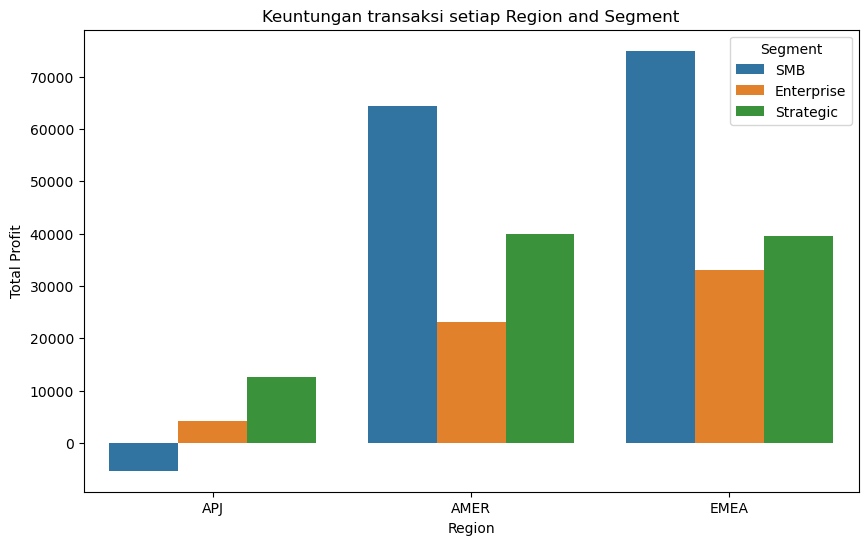

In [42]:
grouped_data_segment = df.groupby(['Region','Segment'])['Profit'].sum().sort_values().reset_index()

# Membuat bar plot
plt.figure(figsize=(10, 6))
sns.barplot(y='Profit', x='Region', hue='Segment', data=grouped_data_segment)
plt.title('Keuntungan transaksi setiap Region and Segment')
plt.ylabel('Total Profit')
plt.xlabel('Region')
plt.show()

Insight:
- Region EMEA memberikan kontribusi keuntungan terbesar secara keseluruhan, dengan segment SMB sebagai kontributor terbesar di region ini.
- Region AMER juga menunjukkan keuntungan yang signifikan, dengan distribusi keuntungan yang relatif sama dengan region EMEA
- Region APJ memiliki keuntungan terendah di antara ketiganya, dengan segment Strategic sebagai kontributor terbesar, meskipun jumlahnya masih - jauh di bawah segment di region lain.
- Segment SMB pada region APJ mengalami kerugian dan hanya terjadi disini.

### **Analisa Pengaruh Industry Terhadap Keuntungan**

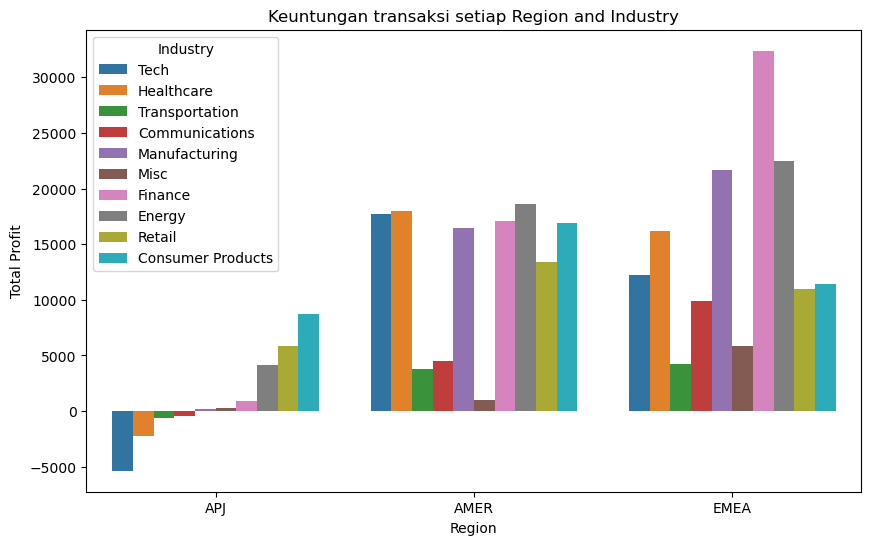

In [43]:
grouped_data_industry = df.groupby(['Region','Industry'])['Profit'].sum().sort_values().reset_index()

# Membuat bar plot
plt.figure(figsize=(10, 6))
sns.barplot(y='Profit', x='Region', hue='Industry', data=grouped_data_industry)
plt.title('Keuntungan transaksi setiap Region and Industry')
plt.ylabel('Total Profit')
plt.xlabel('Region')
plt.show()

Insight:
- Setiap industri memiliki keuntungan transaksi yang berbeda pada tiap region yang ada
- Top Industri tiap region: EMEA memiliki keuntungan transaksi terbaik pada Finance, Amer pada Energy, dan APJ pada Consumer Product
- Worst Industri tiap region: EMEA memiliki keuntungan transaksi terburuk pada transportation, AMER pada Misc, dan APJ pada Tech.

# **Kesimpulan**


Berdasarkan Analisa yang telah dilakukan berdasarkan pernyataan masalah yang ada dapat disimpulkan bahwa:
1. Tren Penjualan dan Keuntungan Dalam 3 tahun terakhir cenderung mengingkat, namun setelah dilihat setiap bulannya ada fluktuasi yang dapat dipengaruhi beberapa faktor diantaranya adalah quantity setiap bulan dan untuk keuntungan dipengaruhi oleh discount yang diberikan
2. Customer paling berharga adalah mereka yang memiliki Customer Segment 'Champions' diantaranya adalah:
- Chevron
- BNP Paribas
- Mondelez International
- Tyson Foods
- Itochu
- AmerisourceBergen- 
- Johnson & Johnson
- Kroger-
- Allstate
- Allianz 

Namun ada fenemoena unik pada Customer Allstate: Meskipun spending perusahaan ini tinggi, ternyata perusahaan mengalami kerugian setelah melakukan transaksi dengan Allstate selama 3 tahun terkahir.

3. Faktor yang mempengaruhi keuntungan diantaranya adalah:
- Diskon: Discount yang besar dapat membuat perusahaan kehilangan keuntungan sebanyak 2x lipat
- Region: Setiap region memiliki perbedaan keuntungan yang disebabkan perbedaan prefensi dari


# **Rekomendasi**

1. Optimalisasi Strategi Diskon:
- Lakukan analisis mendalam terhadap dampak diskon terhadap keuntungan. Khususnya, identifikasi titik impas di mana diskon masih menghasilkan profitabilitas positif dan gunakan informasi ini untuk menyesuaikan strategi penetapan harga.
- Pertimbangkan penerapan diskon dinamis yang berbasis pada perilaku pembelian pelanggan, volume pembelian, dan frekuensi pembelian untuk memaksimalkan keuntungan.
2. Analisis Fluktuasi Bulanan:
- Kembangkan sistem pemantauan yang lebih cermat untuk mengidentifikasi dan menganalisis faktor-faktor yang menyebabkan fluktuasi penjualan bulanan.
- Gunakan analisis data untuk memahami tren musiman dan merencanakan promosi atau penyesuaian inventaris sesuai dengan tren tersebut.
3. Meningkatkan Relasi dengan Pelanggan ‘Champions’:
- Tingkatkan interaksi dan personalisasi layanan dengan pelanggan dari segmen 'Champions' untuk memperkuat loyalitas dan meningkatkan frekuensi transaksi.
- Evaluasi ulang hubungan dengan Allstate dan cari tahu penyebab kerugian yang terjadi. Pertimbangkan renegosiasi ketentuan atau kondisi yang lebih menguntungkan jika diperlukan.
4. Analisis Regional Keuntungan:
- Lakukan analisis komprehensif terhadap performa regional untuk mengidentifikasi area-area dengan performa buruk dan alasan di baliknya.
- Kembangkan strategi pemasaran yang disesuaikan dengan preferensi dan kebutuhan khusus di setiap region untuk meningkatkan keuntungan.
5. Pelatihan dan Pengembangan Tim Penjualan:
- Sediakan pelatihan berkala untuk tim penjualan mengenai strategi penjualan yang efektif, negosiasi, dan penggunaan data untuk penjualan.
- Motivasi tim penjualan dengan insentif yang dihubungkan langsung dengan pencapaian target yang berorientasi keuntungan.

# **Menyimpan CSV Terupdate Untuk Kebutuhan Tableau**

In [45]:
df.isna().sum()

Order ID            0
Order Date          0
Contact Name        0
Country             0
City                0
Region              0
Subregion           0
Customer            0
Customer ID         0
Industry            0
Segment             0
Product             0
Sales               0
Quantity            0
Discount            0
Profit              0
Customer Segment    0
COGS                0
Profit Bef Disc     0
dtype: int64

In [46]:
df.to_csv('saas_sales.xlsx', index=False)

# **Tableau Access**
https://public.tableau.com/app/profile/banu.baskara.devar/viz/SaaSSalesDashboard_17140584287920/Home?publish=yes